# seq2seq (Sequence-to-Sequence)

In [1]:
# 모델 시각화 패키지 install
# !pip install pydot  pydotplus graphviz

### Embeding Vector 준비

1. 영어 glove 임베딩(사전 학습) 사용 / 6B tokens, 400K vocab, uncased, 100d
2. 한국어 임베딩 (초기 훈련)

In [2]:
# !gdown 1UK61mxiWzP1XPvJ53KXa7L7-ETbDYKgc

### 학습 데이터 준비 

http://www.manythings.org/anki/

eng - kor 짝으로 이루어진 학습 데이터

1. Encoder 입력 데이터 eng
    - encoder_input_eng 준비 'I love you'
2. Decoder 출력 데이터 kor
    - 학습용 teacher-forcing 모델
        - decoder_input_kor '<sos> 난 널 사랑해'
        - decoder_output_kor '난 널 사랑해 <eos>'
    - 추론용 모델

In [3]:
# !gdown 1sfIbATWOTpYiJZbl9NClZ9ZhbSvdR1Wz -O eng_kor.txt

In [4]:
eng_inputs = []     # 인코더 입력
kor_inputs = []     # 디코더 입력
kor_targets = []     # 디코더 출력

with open('eng_kor.txt', 'r', encoding='utf-8') as f:
    for line in f:
        eng, kor, _ = line.split('\t')
        
        kor_input = '<sos> ' + kor
        kor_target = kor + ' <eos>'
        eng_inputs.append(eng)
        kor_inputs.append(kor_input)  # \n 제거
        kor_targets.append(kor_target)   # \n 제거
        
len(eng_inputs), len(kor_inputs), len(kor_targets)

(5890, 5890, 5890)

In [5]:
print(eng_inputs[1000:1005])
print(kor_inputs[1000:1005])
print(kor_targets[1000:1005])

["I'm just sleepy.", "I'm not sulking.", "I'm on the list.", 'Is Tom with you?', 'Is anybody home?']
['<sos> 나 졸려.', '<sos> 나 삐친 거 아니야.', '<sos> 나는 명단에 있다.', '<sos> 톰이랑 같이 있어?', '<sos> 누구 집에 있어요?']
['나 졸려. <eos>', '나 삐친 거 아니야. <eos>', '나는 명단에 있다. <eos>', '톰이랑 같이 있어? <eos>', '누구 집에 있어요? <eos>']


### 토큰화
- 인코더(영어) : 영문 토커나이저
- 디코더(한글) : 국문 토커나이저

In [6]:
VOCAB_SIZE = 10000

### 영문 토큰화

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer

eng_tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
eng_tokenizer.fit_on_texts(eng_inputs)
eng_inputs_seq = eng_tokenizer.texts_to_sequences(eng_inputs)

eng_inputs_seq[1000:1005]

[[16, 114, 487],
 [16, 32, 1915],
 [16, 49, 6, 1916],
 [7, 3, 45, 5],
 [7, 367, 89]]

In [8]:
for seq in eng_inputs_seq[1000:1005]:
    print([eng_tokenizer.index_word[index] for index in seq])

["i'm", 'just', 'sleepy']
["i'm", 'not', 'sulking']
["i'm", 'on', 'the', 'list']
['is', 'tom', 'with', 'you']
['is', 'anybody', 'home']


In [9]:
eng_num_words = min(VOCAB_SIZE, len(eng_tokenizer.word_index))

In [10]:
eng_max_len = max([len(seq) for seq in eng_inputs_seq])

### 국문 토큰화

In [11]:
# filters='' 필터사용안함 (기본값: filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
kor_tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>', filters='')
kor_tokenizer.fit_on_texts(kor_inputs + kor_targets) # <sos> <eos> 포함

kor_inputs_seq = kor_tokenizer.texts_to_sequences(kor_inputs)
kor_targets_seq = kor_tokenizer.texts_to_sequences(kor_targets)

kor_inputs_seq[1000:1005], kor_targets_seq[1000:1005]

([[2, 81, 1655],
  [2, 81, 3224, 171, 110],
  [2, 5, 3225, 15],
  [2, 160, 120, 16],
  [2, 436, 55, 534]],
 [[81, 1655, 3],
  [81, 3224, 171, 110, 3],
  [5, 3225, 15, 3],
  [160, 120, 16, 3],
  [436, 55, 534, 3]])

In [12]:
kor_tokenizer.index_word

{1: '<OOV>',
 2: '<sos>',
 3: '<eos>',
 4: '톰은',
 5: '나는',
 6: '톰이',
 7: '난',
 8: '있어.',
 9: '그',
 10: '내가',
 11: '수',
 12: '이',
 13: '내',
 14: '그는',
 15: '있다.',
 16: '있어?',
 17: '네가',
 18: '것',
 19: '우리는',
 20: '것을',
 21: '더',
 22: '왜',
 23: '할',
 24: '너무',
 25: '너',
 26: '좀',
 27: '안',
 28: '네',
 29: '정말',
 30: '거야.',
 31: '않아.',
 32: '우리',
 33: '한',
 34: '없어.',
 35: '같아.',
 36: '그녀는',
 37: '알고',
 38: '걸',
 39: '것이다.',
 40: '프랑스어를',
 41: '있는',
 42: '없다.',
 43: '줄',
 44: '한다.',
 45: '않는다.',
 46: '이건',
 47: '우린',
 48: '잘',
 49: '가장',
 50: '해.',
 51: '너는',
 52: '톰을',
 53: '하고',
 54: '적',
 55: '집에',
 56: '사람은',
 57: '했다.',
 58: '그걸',
 59: '아무도',
 60: '여기',
 61: '있을',
 62: '건',
 63: '날',
 64: '넌',
 65: '것은',
 66: '그렇게',
 67: '메리가',
 68: '톰과',
 69: '했어.',
 70: '지금',
 71: '않았다.',
 72: '톰의',
 73: '오늘',
 74: '무슨',
 75: '얼마나',
 76: '그게',
 77: '좋은',
 78: '것이',
 79: '아주',
 80: '그의',
 81: '나',
 82: '그것을',
 83: '하지',
 84: '그건',
 85: '어떻게',
 86: '있었어.',
 87: '적이',
 88: '못',
 89: '우리가',
 90: '그가',
 

In [13]:
kor_num_words = min(VOCAB_SIZE, len(kor_tokenizer.word_index))

In [14]:
kor_max_len = max([len(seq) for seq in kor_inputs_seq])

### 패딩 처리
- 인코더 padding = 'pre'
- 디코더 padding = 'post'

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

eng_inputs_padded = pad_sequences(eng_inputs_seq, maxlen=eng_max_len, padding='pre')
kor_inputs_padded = pad_sequences(kor_inputs_seq, maxlen=kor_max_len, padding='post')
kor_target_padded = pad_sequences(kor_targets_seq, maxlen=kor_max_len, padding='post')

eng_inputs_padded.shape , kor_inputs_padded.shape, kor_target_padded.shape

((5890, 101), (5890, 90), (5890, 90))

### 모델 학습

'encoder + decoder(teacher_forcing)' 구조의 모델을 생성 및 학습
- 영문 Embedding Layer는 glove.6B.100d의 사전 학습 모델 사용

##### Embedding Layer

In [16]:
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for i, vects in enumerate(f):
        print(vects)
        if i == 5:
            break

the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787 -0.06731 0.30906 -0.26384 -0.13231 -0.20757 0.33395 -0.33848 -0.31743 -0.48336 0.1464 -0.37304 0.34577 0.052041 0.44946 -0.46971 0.02628 -0.54155 -0.15518 -0.14107 -0.039722 0.28277 0.14393 0.23464 -0.31021 0.086173 0.20397 0.52624 0.17164 -0.082378 -0.71787 -0.41531 0.20335 -0.12763 0.41367 0.55187 0.57908 -0.33477 -0.36559 -0.54857 -0.062892 0.26584 0.30205 0.99775 -0.80481 -3.0243 0.01254 -0.36942 2.2167 0.72201 -0.24978 0.92136 0.034514 0.46745 1.1079 -0.19358 -0.074575 0.23353 -0.052062 -0.22044 0.057162 -0.15806 -0.30798 -0.41625 0.37972 0.15006 -0.53212 -0.2055 -1.2526 0.071624 0.70565 0.49744 -0.42063 0.26148 -1.538 -0.30223 -0.073438 -0.28312 0.37104 -0.25217 0.016215 -0.017099 -0.38984 0.87424 -0.72569 -0.51058 -0.52028 -0.1459 0.8278 0.27062

, -0.10767 0.11053 0.59812 -0.54361 0.67396 0.10663 0.038867 0.35481 0.06351 -0.094189 0.15786 -0.81665 0.14172 0.21939 0.58505 -0.52158

In [17]:
import numpy as np

def make_embedding_matrix(num_words, embedding_dim, tokenizer, file_path):
    embedding_matrix = np.zeros((num_words + 1, embedding_dim))
    
    pretrained_embedding = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            word, *vects = line.split()
            vects = np.array(vects, dtype=np.float32)
            pretrained_embedding[word] = vects
            
        for word, index in tokenizer.word_index.items():  
            vects_ = pretrained_embedding.get(word)
            if vects_ is not None:
                embedding_matrix[index] = vects
        
        return embedding_matrix


In [18]:
EMBEDDING_DIM = 100

en_embedding_matrix = make_embedding_matrix(
    eng_num_words, 
    EMBEDDING_DIM, 
    eng_tokenizer, 
    'glove.6B.100d.txt'
)

en_embedding_matrix.shape

(3201, 100)

In [19]:
import pandas as pd

eng_word_index = eng_tokenizer.word_index 
eng_word_index_with_padding = {0: '<PAD>'} 
eng_word_index_with_padding.update({k: v for v, k in eng_word_index.items()})

pd.DataFrame(en_embedding_matrix, index=eng_word_index_with_padding.values())


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
<PAD>,0.00000,0.0000,0.00000,0.0000,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000,...,0.00000,0.00000,0.000000,0.00000,0.0000,0.000000,0.000000,0.00000,0.00000,0.00000
<OOV>,0.00000,0.0000,0.00000,0.0000,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000,...,0.00000,0.00000,0.000000,0.00000,0.0000,0.000000,0.000000,0.00000,0.00000,0.00000
i,0.28365,-0.6263,-0.44351,0.2177,-0.087421,-0.17062,0.29266,-0.024899,0.26414,-0.17023,...,0.13885,-0.22862,0.071792,-0.43208,0.5398,-0.085806,0.032651,0.43678,-0.82607,-0.15701
tom,0.28365,-0.6263,-0.44351,0.2177,-0.087421,-0.17062,0.29266,-0.024899,0.26414,-0.17023,...,0.13885,-0.22862,0.071792,-0.43208,0.5398,-0.085806,0.032651,0.43678,-0.82607,-0.15701
to,0.28365,-0.6263,-0.44351,0.2177,-0.087421,-0.17062,0.29266,-0.024899,0.26414,-0.17023,...,0.13885,-0.22862,0.071792,-0.43208,0.5398,-0.085806,0.032651,0.43678,-0.82607,-0.15701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
whom,0.28365,-0.6263,-0.44351,0.2177,-0.087421,-0.17062,0.29266,-0.024899,0.26414,-0.17023,...,0.13885,-0.22862,0.071792,-0.43208,0.5398,-0.085806,0.032651,0.43678,-0.82607,-0.15701
intimately,0.28365,-0.6263,-0.44351,0.2177,-0.087421,-0.17062,0.29266,-0.024899,0.26414,-0.17023,...,0.13885,-0.22862,0.071792,-0.43208,0.5398,-0.085806,0.032651,0.43678,-0.82607,-0.15701
millions,0.28365,-0.6263,-0.44351,0.2177,-0.087421,-0.17062,0.29266,-0.024899,0.26414,-0.17023,...,0.13885,-0.22862,0.071792,-0.43208,0.5398,-0.085806,0.032651,0.43678,-0.82607,-0.15701
inhabit,0.28365,-0.6263,-0.44351,0.2177,-0.087421,-0.17062,0.29266,-0.024899,0.26414,-0.17023,...,0.13885,-0.22862,0.071792,-0.43208,0.5398,-0.085806,0.032651,0.43678,-0.82607,-0.15701


##### 인코더 모델

In [20]:
from tensorflow.keras import layers, models

LARENT_DIM = 512

encoder_inputs = layers.Input(shape=(eng_max_len,))
en_embedding_layer = layers.Embedding(eng_num_words + 1, EMBEDDING_DIM, weights=[en_embedding_matrix])

x = en_embedding_layer(encoder_inputs)
encoder_outputs, h, c = layers.LSTM(LARENT_DIM, return_state=True)(x)
encoder_states = [h, c]


encoder_model = models.Model(encoder_inputs, encoder_states)

encoder_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 101)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 101, 100)       │       320,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ [(None, 512), (None,   │     1,255,424 │
│                                 │ 512), (None, 512)]     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,575,524 (6.01 MB)

 Trainable params: 1,575,524 (6.01 MB)

 Non-trainable params: 0 (0.00 B)

##### 디코더 모델 (Teacher-forcing)

In [21]:
decoder_inputs = layers.Input(shape=(kor_max_len,))
ko_embedding_layer = layers.Embedding(kor_num_words + 1, EMBEDDING_DIM)
x = ko_embedding_layer(decoder_inputs)
decoder_lstm = layers.LSTM(LARENT_DIM, return_sequences=True, return_state=True)
x, h, c = decoder_lstm(x, initial_state=encoder_states)

decoder_dense = layers.Dense(kor_num_words + 1, activation='softmax')
decoder_outputs = decoder_dense(x)

decoder_teacher_forcing_model = models.Model(
    inputs=[encoder_inputs, decoder_inputs], 
    outputs=decoder_outputs
)

decoder_teacher_forcing_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 101)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 90)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 101, 100)  │    320,100 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 90, 100)   │    828,900 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 512),     │  1,255,424 │ embedding[0][0]   │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 90, 512), │  1,255,424 │ embedding_1[0][0… │
│                     │ (None, 512),      │            │ lstm[0][1],       │
│                     │ (None, 512)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 90, 8289)  │  4,252,257 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,912,105 (30.18 MB)

 Trainable params: 7,912,105 (30.18 MB)

 Non-trainable params: 0 (0.00 B)

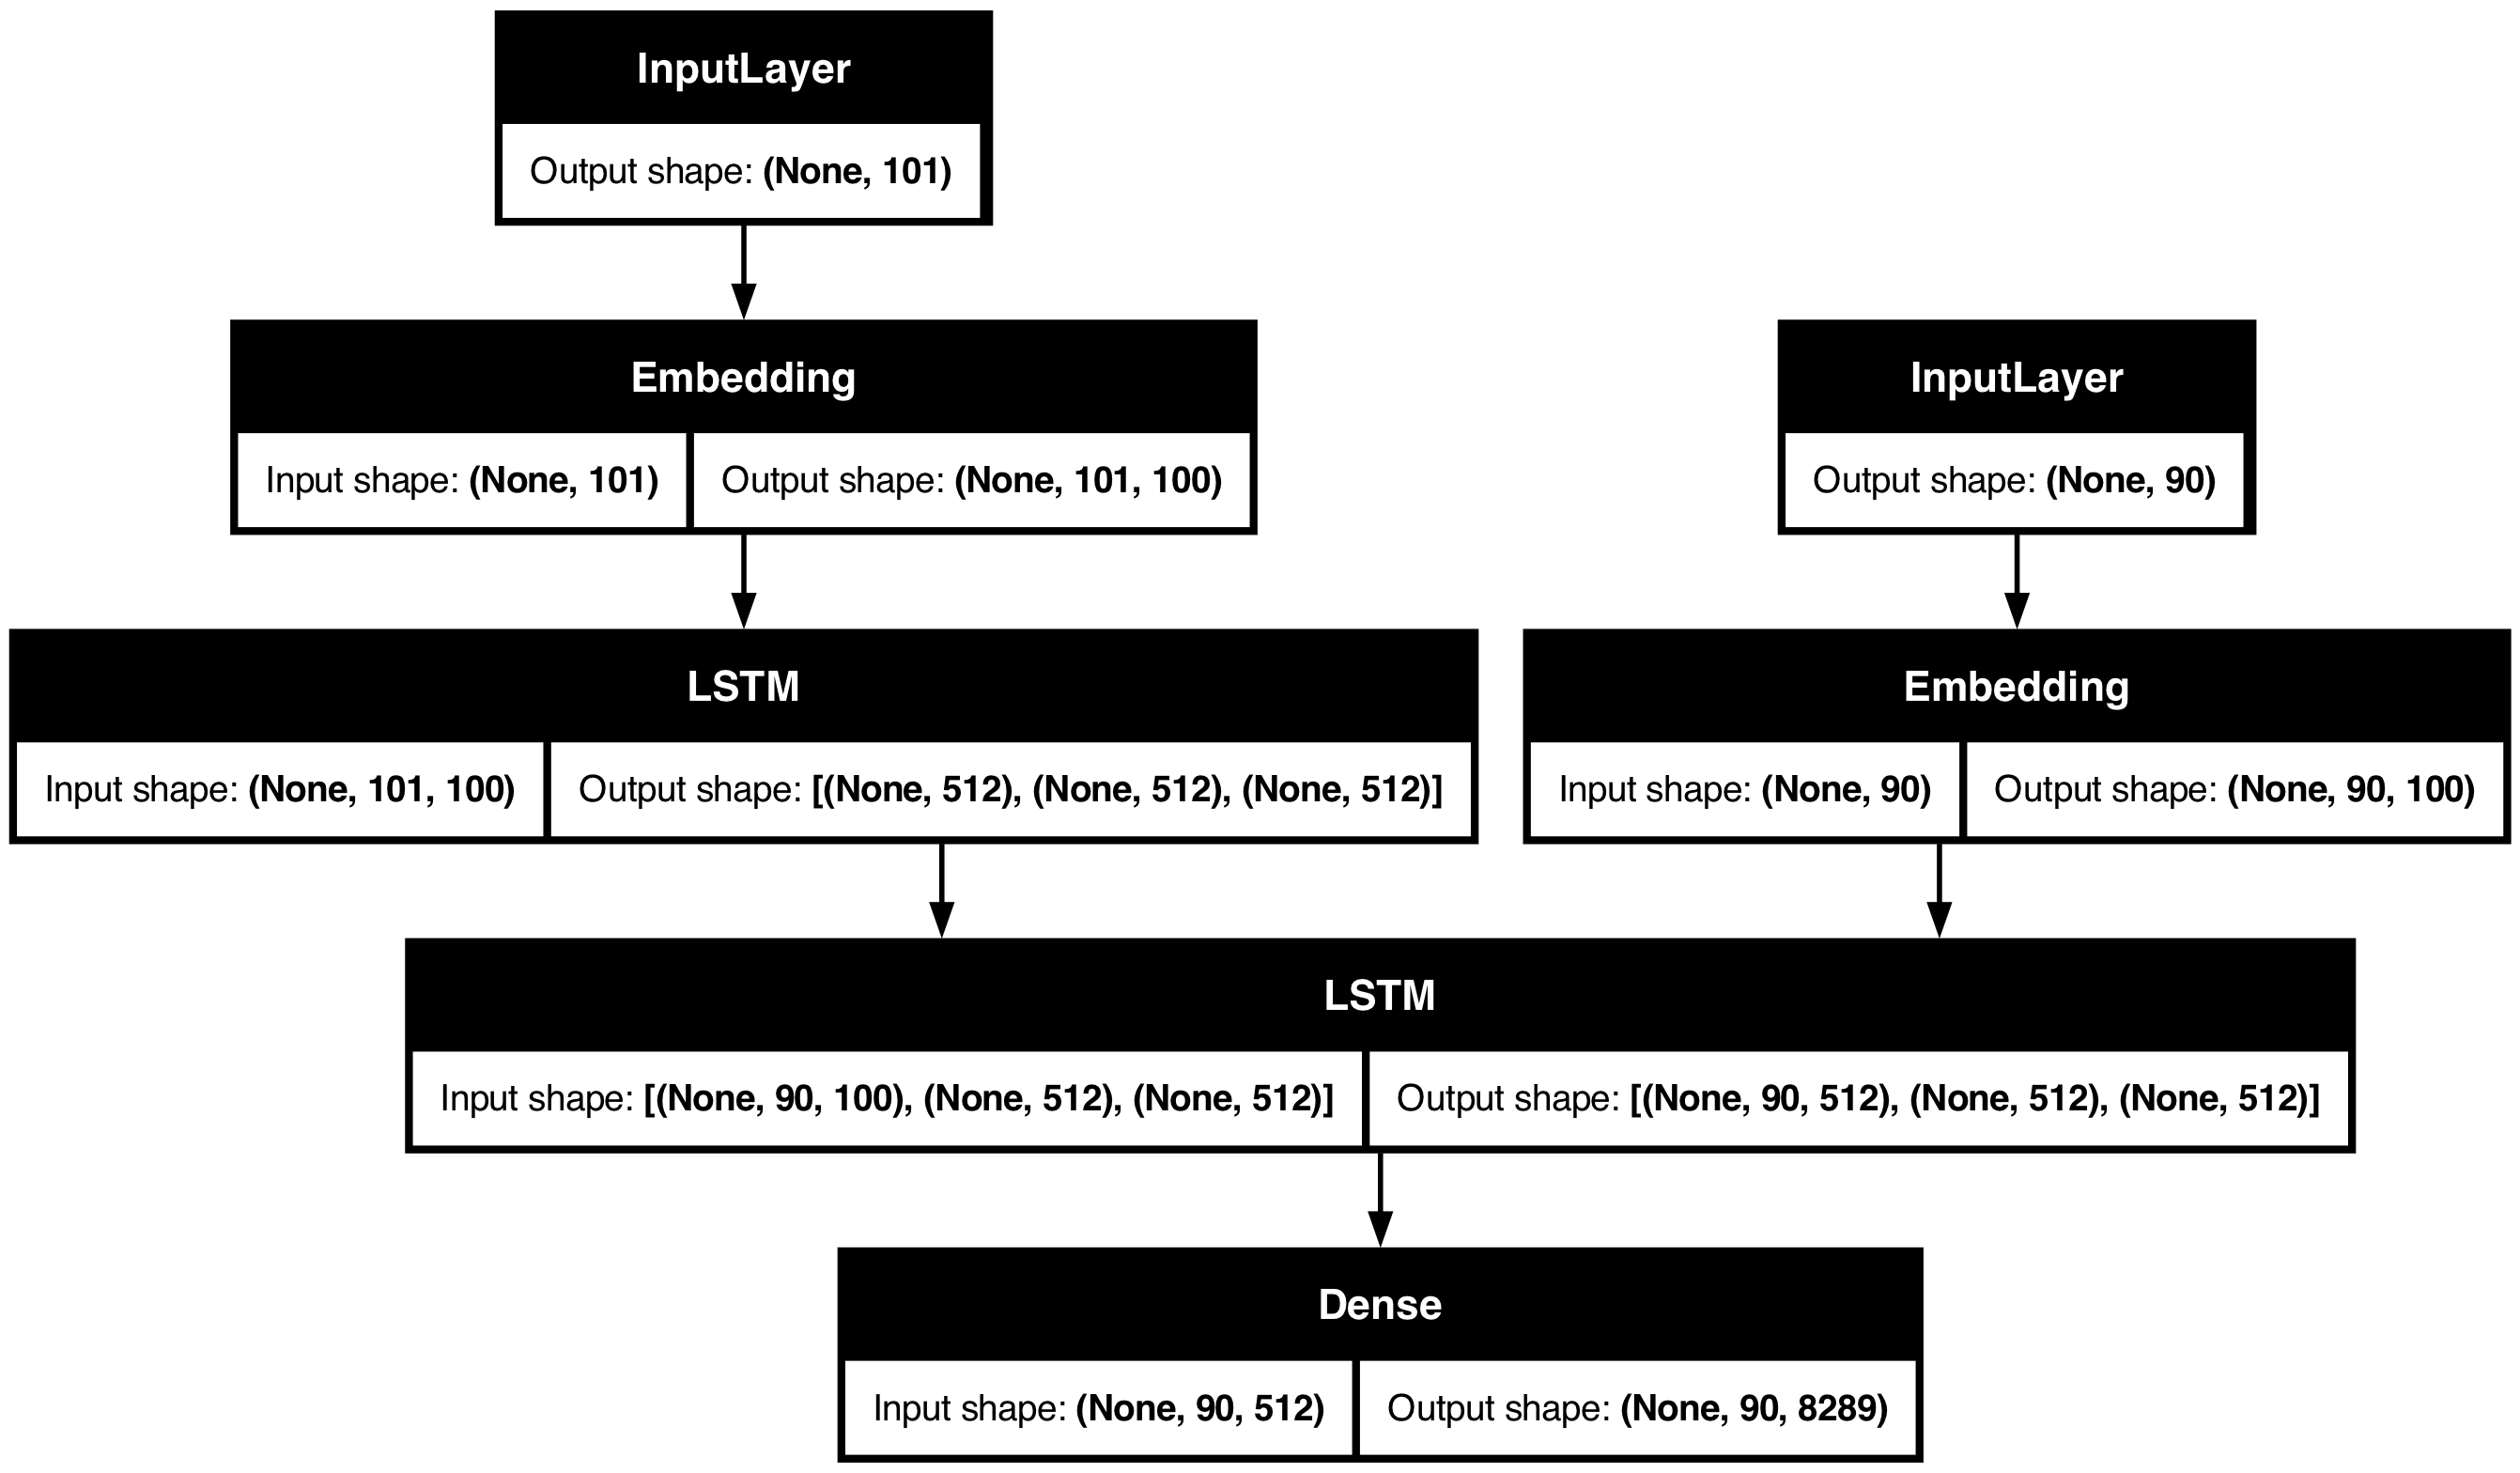

In [22]:
# teacher-forcing model 시각화
from tensorflow.keras.utils import plot_model

plot_model(decoder_teacher_forcing_model, show_shapes=True)


##### 모델 학습

In [24]:
decoder_teacher_forcing_model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

history = decoder_teacher_forcing_model.fit(
    [eng_inputs_padded, kor_inputs_padded],
    kor_target_padded,
    batch_size=64,
    epochs=3,
    validation_split=0.2 
)

Epoch 1/3
74/74 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.9897 - loss: 0.0509 - val_accuracy: 0.9329 - val_loss: 0.8053
Epoch 2/3
74/74 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.9913 - loss: 0.0450 - val_accuracy: 0.9331 - val_loss: 0.8217
Epoch 3/3
74/74 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.9920 - loss: 0.0415 - val_accuracy: 0.9327 - val_loss: 0.8300


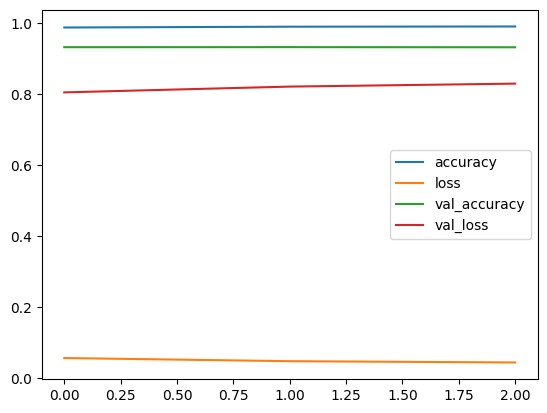

In [25]:
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot()
plt.show()

In [26]:
# 모델 저장
decoder_teacher_forcing_model.save('decoder_techer_forcing_model.keras')

In [27]:
# 모델 로드 
from tensorflow.keras.models import load_model
decoder_teacher_forcing_model = load_model('decoder_techer_forcing_model.keras')

###  모델 추론
'encoder + decoder(inference)' 구조의 모델로 추론

##### 디코더 추론 모델

In [29]:
decoder_hidden_state = layers.Input(shape=(LARENT_DIM,))
decoder_cell_state = layers.Input(shape=(LARENT_DIM,))
decoder_states_inputs = [decoder_hidden_state, decoder_cell_state]

decoder_single_input = layers.Input(shape=(1,))

x = ko_embedding_layer(decoder_single_input)

x, h, c = decoder_lstm(x, initial_state=decoder_states_inputs)
decoder_state = [h, c]

decoder_outputs_ = decoder_dense(x)

decoder_inference_model = models.Model(
    inputs=[decoder_single_input] + decoder_states_inputs,
    outputs=[decoder_outputs_] + decoder_states_inputs
)

decoder_inference_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 100)    │    828,900 │ input_layer_7[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 1, 512),  │  1,255,424 │ embedding_1[2][0… │
│                     │ (None, 512),      │            │ input_layer_5[0]… │
│                     │ (None, 512)]      │            │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 8289)   │  4,252,257 │ lstm_1[2][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,336,581 (24.17 MB)

 Trainable params: 6,336,581 (24.17 MB)

 Non-trainable params: 0 (0.00 B)

##### 추론 함수

In [30]:
def translate(input_seq):
    # input_seq 통과 (추론) -> hidden state, cell state 만 변환
    encoder_states_value = encoder_model.predict(input_seq)
    decoder_states_value = encoder_states_value
    
    # 디코더
    # 1. <sos><eos>
    sos_index = kor_tokenizer.word_index['<sos>']
    eos_index = kor_tokenizer.word_index['<eos>']
    
    # 2.target_seq 준비 (디코더 출력)
    target_seq = np.zeros((1, 1))
    target_seq[0,0] = sos_index
    
    # 순차적으로 디코딩(= 번역)
    output_sentence = []
    
    for _ in range(kor_max_len):
        output_tokens, h, c = decoder_inference_model.predict([target_seq] + decoder_states_value)
        
        pred_proba = output_tokens[0, 0, :] 
        pred_index = np.argmax(pred_proba)
        
        if pred_index == eos_index:
            break
        
        if pred_index > 0:
            word = kor_tokenizer.index_word[pred_index]
            output_sentence.append(word)
            
        target_seq[0, 0] = pred_index
        decoder_states_value = [h, c]
    
    return " ".join(output_sentence)

In [31]:
print(eng_inputs[:1])

input_seq = eng_inputs_padded[:1]
output_sent = translate(input_seq)

print(output_sent)

['Go.']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
안녕!


In [32]:
for _ in range(5):
    idx = np.random.choice(len(eng_inputs_padded))
    input_seq = eng_inputs_padded[idx: idx+1]
    output_sent = translate(input_seq)
    display("입력 영문:", eng_inputs[idx])
    display('학습한 국문:', kor_inputs[idx])
    display('추론한 국문:', output_sent)
    display()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

'입력 영문:'

"Tom said that he didn't think the heat bothered Mary."

'학습한 국문:'

'<sos> 톰은 더위가 메리를 괴롭힌다고 생각하지 않았다고 말했다.'

'추론한 국문:'

'톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

'입력 영문:'

'Tom put on his helmet and then got on his motorcycle.'

'학습한 국문:'

'<sos> 톰은 헬멧을 쓰고 오토바이에 올라탔다.'

'추론한 국문:'

'톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은 톰은'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

'입력 영문:'

'My younger sister plays piano every day.'

'학습한 국문:'

'<sos> 우리 여동생은 날마다 피아노를 친다.'

'추론한 국문:'

'내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내 내'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

'입력 영문:'

'Why are you acting this way?'

'학습한 국문:'

'<sos> 왜 이렇게 행동하는 거야?'

'추론한 국문:'

'왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜 왜'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

'입력 영문:'

'We study the past for the sake of the future.'

'학습한 국문:'

'<sos> 우리는 미래를 위해 과거를 공부해.'

'추론한 국문:'

'우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는 우리는'

In [33]:
def translate_eng2kor(eng_text):
    # 입력 데이터 전처리
    input_seq = eng_tokenizer.texts_to_sequences(eng_text)
    input_seq = pad_sequences(input_seq, maxlen=eng_max_len)
    return translate(input_seq) # 추론 함수 호출

eng_texts = [
    "My rips are red,",
    "French is interesting.",
    'I like bus',
    "Let\'s study",
    "I ate sandwich"
]

for eng_text in eng_texts:
    kor_text = translate_eng2kor([eng_texts])
    display(eng_text, kor_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

'My rips are red,'

'내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

'French is interesting.'

'내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

'I like bus'

'내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

"Let's study"

'내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

'I ate sandwich'

'내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가'

### 모델 추론